<a href="https://colab.research.google.com/github/Nomad653/Anomaly-detection/blob/main/anomaly_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import random
from distutils.version import LooseVersion as version
from itertools import product

In [ ]:
def seed_setting(sd):
  os.environ['PL_GLOBAL_SEED'] = str(sd)
  random.seed(sd)
  np.random.seed(sd)
  torch.manual_seed(sd)
  torch.cuda.manual_seed_all(sd)

def fn_det_setting():
  if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


  if torch.__version__ <= Version("1.7"):
    torch.fn_det_setting(True)
  else:
    torch.use_deterministic_algorithms(True)
    

In [ ]:
RNDM_SEED = 245
btch_input_sz = 128
epch_nmbr = 25
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
DEVICE

device(type='cuda', index=0)

In [ ]:
seed_setting(RNDM_SEED)


In [ ]:
#Traininf images path
tr_ds_path = '/content/drive/MyDrive/chest_xray/chest_xray/train/'

#Validation images path
vd_ds_path = "/content/drive/MyDrive/chest_xray/chest_xray/val/"

ts_ds_path = "/content/drive/MyDrive/chest_xray/chest_xray/test/"

In [ ]:
import torch.utils.data as data

In [ ]:
tr_data_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485,0.456,0.406),
                                     (0.229,0.224,0.225))
])

validation_data_trans = torchvision.transforms.Compose([
    
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.CenterCrop((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485,0.456,0.406),
                                     (0.229,0.224,0.225))
])

tst_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.CenterCrop((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485,0.456,0.406),
                                     (0.229,0.224,0.225))
])

In [ ]:
train_ds_cln = torchvision.datasets.ImageFolder(root=tr_ds_path,transform = tr_data_trans)
train_loader_cln = data.DataLoader(train_ds_cln,batch_size=206,shuffle=True)

test_ds_cln = torchvision.datasets.ImageFolder(root=ts_ds_path,transform = tst_data_transform)
test_loader_cln = data.DataLoader(test_ds_cln,batch_size=63,shuffle=True)

valid_ds_cln = torchvision.datasets.ImageFolder(root=vd_ds_path,transform= validation_data_trans)
valid_loader_cln = data.DataLoader(valid_ds_cln,batch_size=63,shuffle=True)


In [ ]:
for images,labels in train_loader_cln:
  print("Image batch dimensions: ",images.shape)
  print("Image label dimensions: ",labels.shape)
  print("Class labels of 10 examples: ",labels[:10])
  break

KeyboardInterrupt: ignored

In [ ]:
model = torchvision.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 400MB/s]


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
model.classifier[1].requires_grad = True
model.classifier[3].requires_grad = True

In [ ]:
model.classifier[6] = torch.nn.Linear(4096,2)

In [ ]:
def find_acc_metric(input_model,input_data_ldr,dvc):
  with torch.no_grad():
    correct_pred, num_examples = 0,0
    for i, (features,targets) in enumerate(input_data_ldr):
      features = features.to(dvc)
      targets = targets.float().to(dvc)

      preds = input_model(features)
      _,predicted_labels = torch.max(preds,1)

      num_examples +=targets.size(0)
      correct_pred +=(predicted_labels ==targets).sum()
  return correct_pred.float()/num_examples * 100

In [ ]:
def mdl_training(model,epch_nmbr,train_loader,
                 valid_loader,test_loader,optimizer,
                 device,logging_interval=50,
                 scheduler = None,
                 scheduler_on = "valid_acc"):
  tme_strt = time.time()
  list_from_loss, accuracy_train, accuracy_validation = [],[],[]


  for epch in range(epch_nmbr):

    model.train()
    for batch_idx, (features,targets) in enumerate(train_loader):
      features = features.to(device)
      targets = targets.to(device)

      #Forward and back prop

      preds = model(features)
      loss = torch.nn.functional.cross_entropy(preds,targets)
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()


      # Logging
      list_from_loss.append(loss.item())
      if not batch_idx % logging_interval:
        print(f"Epoch: {epch+1:03d}/{epch_nmbr:03d}" f" | Batch {batch_idx:04d}/{len(train_loader):04d}" f"| Loss: {loss:.4f}")
      model.eval()
      with torch.no_grad():
        train_acc = find_acc_metric(model,train_loader,dvc=device)
        valid_acc = find_acc_metric(model,valid_loader,dvc=device)
        print(f"Epoch: {epch+1:03d}/{epch_nmbr:03d}"
              f"| Train: {train_acc:.2f}%"
              f"|Validation: {valid_acc :.2f}%")
        accuracy_train.append(train_acc.item())
        accuracy_validation.append(valid_acc.item())
      tr_time = (time.time() - tme_strt)/60
      print(f"Time tr_time: {tr_time:.2f} min")
      if scheduler is not None:
        if scheduler_on == "valid_acc":
          scheduler.step(accuracy_validation[-1])
        elif scheduler_on == "minibatch_loss":
          scheduler.step(list_from_loss[-1])
        
        else:
          raise ValueError(f"Invalid 'scheduler_on' choice.")
  tr_time = (time.time() - tme_strt)/60
  print(f"Final training time: {tr_time:.2f} min")


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(),momentum=0.9,lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,mode="max",verbose=True)

list_from_loss,accuracy_train,accuracy_validation = mdl_training(model=model,
                                                                 epch_nmbr=5,
                                                                 train_loader=train_loader_cln,
                                                                 valid_loader=valid_loader_cln,
                                                                 test_loader=test_loader_cln,
                                                                 optimizer=optimizer,
                                                                 device=DEVICE,
                                                                 scheduler = scheduler,
                                                                 scheduler_on = "valid_acc",
                                                                 logging_interval=100
                                                                 
                                                                 )

Epoch: 001/005 | Batch 0000/0026| Loss: 0.5361
Epoch: 001/005| Train: 53.76%|Validation: 62.50%
Time tr_time: 1.84 min
Epoch: 001/005| Train: 74.33%|Validation: 50.00%
Time tr_time: 3.68 min
Epoch: 001/005| Train: 74.54%|Validation: 50.00%
Time tr_time: 5.52 min
Epoch: 001/005| Train: 86.18%|Validation: 75.00%
Time tr_time: 7.35 min
Epoch: 001/005| Train: 80.12%|Validation: 87.50%
Time tr_time: 9.19 min
Epoch: 001/005| Train: 88.32%|Validation: 56.25%
Time tr_time: 11.03 min
Epoch: 001/005| Train: 82.99%|Validation: 50.00%
Time tr_time: 12.87 min
Epoch: 001/005| Train: 89.28%|Validation: 56.25%
Time tr_time: 14.71 min
Epoch: 001/005| Train: 88.38%|Validation: 81.25%
Time tr_time: 16.55 min
Epoch: 001/005| Train: 87.15%|Validation: 87.50%
Time tr_time: 18.39 min
Epoch: 001/005| Train: 90.86%|Validation: 81.25%
Time tr_time: 20.23 min
Epoch: 001/005| Train: 90.59%|Validation: 62.50%
Time tr_time: 22.06 min
Epoch: 001/005| Train: 90.74%|Validation: 62.50%
Time tr_time: 23.89 min
Epoch: 00

KeyboardInterrupt: ignored

In [ ]:
torch.save(model,"93_75.pt")

NameError: ignored

In [ ]:
def example_sample(model,data_loader,unnormalizer=None,class_dict=None):
  for batch_idx, (features,targets) in enumerate(data_loader):

    with torch.no_grad():
      features = features
      targets = targets
      preds = model(features)
      predictions = torch.argmax(preds,dim=1)
    break
  fig,axes = plt.subplots(nrows=3,ncols=5,sharex=True,sharey=True)

  if unnormalizer is not None:
    for idx in range(features.shape[0]):
      features[idx] = unnormalizer(features[idx])
  nhwc_img = np.transpose(features,axes=(0,2,3,1))

  if nhwc_img.shape[-1] ==1:
    nhw_img = np.squeeze(nhwc_img.numpy(),axis=3)

    for idx,ax in enumerate(axes.ravel()):
      ax.imshow(nhw_img[idx],cmap='binary')
      if class_dict is not None:
        ax.title.set_text(f'P:{class_dict[predictions[idx].item()]} | T: {class_dict[targets[idx].item()]}')
      else:
        ax.title.set_text(f'P:{predictions[idx]} | T:{targets[idx]}')
      ax.axison = False
  else:
    for idx, ax in enumerate(axes.ravel()):
      ax.imshow(nhwc_img[idx])
      if class_dict is not None:
        ax.title.set_text(f"P: {class_dict[predictions[idx].item()]}"
        f"\nT: {class_dict[targets[idx].item()]}")
      else:
        ax.title.set_text(f"P: {predictions[idx]} | T:{targets[idx]}")
      ax.axison = False
  plt.tight_layout()
  plt.show()

In [ ]:
class UnNormalize(object):
  def __init__(self,mean,std):
    self.mean = mean
    self.std = std

  def __call__(self,tensor):

    for t,m,s in zip(tensor,self.mean,self.std):
      t.mul_(s).add_(m)

      return tensor

In [ ]:
model = torch.load("/content/drive/MyDrive/anomaly_93_75.pt")
model.cpu()

In [ ]:

unnormalizer = UnNormalize((0.485,0.456,0.406),
                           (0.229,0.224,0.2255))

class_dict = {0:"Normal",
              1: "Anomaly"}

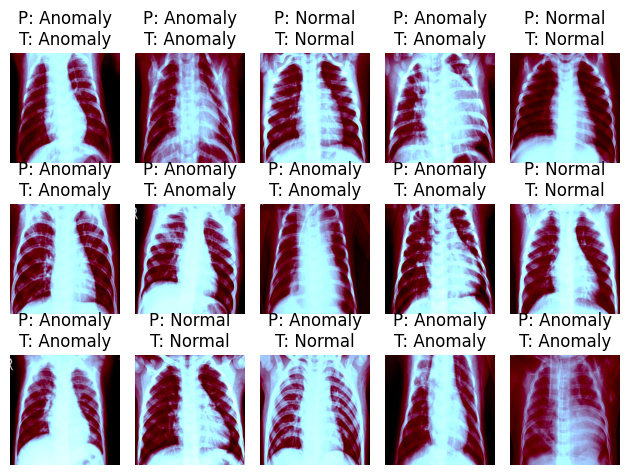

In [ ]:
example_sample(model=model,data_loader=test_loader_cln,unnormalizer=unnormalizer,class_dict=class_dict)

In [ ]:
import os

def count_files_in_folder(folder_path):
    return sum([len(files) for r, d, files in os.walk(folder_path)])

base_path = "/content/drive/MyDrive/chest_xray/chest_xray/"  # Replace with the path to your base directory containing the train, validation, and test folders

folders = ["train", "val", "test"]
labels = ["NORMAL", "PNEUMONIA"]

for folder in folders:
    print(f"--- {folder} ---")
    total_files = 0
    for label in labels:
        label_folder = os.path.join(base_path, folder, label)
        file_count = count_files_in_folder(label_folder)
        total_files += file_count
        print(f"{label}: {file_count} images")
    print(f"Total images in {folder}: {total_files}\n")

print("Imbalance check:")
for folder in folders:
    print(f"--- {folder} ---")
    normal_folder = os.path.join(base_path, folder, "normal")
    pneumonia_folder = os.path.join(base_path, folder, "pneumonia")

    normal_count = count_files_in_folder(normal_folder)
    pneumonia_count = count_files_in_folder(pneumonia_folder)
    imbalance_ratio = normal_count / pneumonia_count

    print(f"Imbalance ratio (normal:pneumonia): {imbalance_ratio:.2f}")
    if 0.75 <= imbalance_ratio <= 1.25:
        print("The dataset is balanced in this split.")
    else:
        print("The dataset is imbalanced in this split.")


--- train ---
NORMAL: 1342 images
PNEUMONIA: 3876 images
Total images in train: 5218

--- val ---
NORMAL: 9 images
PNEUMONIA: 9 images
Total images in val: 18

--- test ---
NORMAL: 234 images
PNEUMONIA: 390 images
Total images in test: 624

Imbalance check:
--- train ---


ZeroDivisionError: ignored